In [1]:
import urllib.request
from bs4 import BeautifulSoup
import re
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#доступ к metacritic.com
SLOW_DOWN = False
def get_html(url):
    # Metacritic запрещает запросы без заголовка User-Agent.
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36"}
    global SLOW_DOWN
    try:
        # Если у нас в каком-либо потоке появилась ошибка 429, то приостанавливаем все потоки
        # на 15 секунд.
        if SLOW_DOWN:
            sleep(15)
            SLOW_DOWN = False
        # Получаем html контент страницы стандартным модулем requests
        html = requests.get(url, headers=headers).content.decode('utf-8')
        # Если ошибка в html контенте, то присваеваем флагу SLOW_DOWN true.
        if '429 Slow down' in html:
            SLOW_DOWN = True
            print(' - - - SLOW DOWN')
            raise TimeoutError
        return html
    except TimeoutError:
        return get_html(url)

In [3]:
#отзывы критиков по DEATH STRANDING
rews = []
dates = []
html = get_html('https://www.metacritic.com/game/playstation-4/death-stranding/critic-reviews')
soup = BeautifulSoup(html, 'html.parser')
for i in soup.find_all('div', {'class':'review_critic'}):
    date = i.find('div', {'class':'date'}).text 
    date = datetime.datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
    dates.append(date)
for i in soup.find_all('div', {'class': 'review_grade'}): 
    mark = i.text.strip('\n')
    rews.append(mark)
#прилипает часть отзыв игроков, их убираем. в отзывах игроков делаем наоборот. 
rews = rews[0:111]
dates = dates[0:111]

d = {'Mark': rews, 'Date': dates}
CRIT = pd.DataFrame(data=d)
CRIT['Mark'] = CRIT['Mark'].astype(int) / 10
CRIT = CRIT.sort_values(by = "Date", ascending = True)
CRIT[['Year','Month', "Day"]] = CRIT.Date.str.split(expand = True, pat = "-")

In [4]:
#отзывы игроков 
#в n передаем количество страниц с отзывами, в filename имя csv в который все будем сохранять

def get_reviews(url, n, filename):
    reviews = []
    finalrews = []
    finaldates = []
    
    for i in range(0, n):
        rews2 = []
        dates2 = []
        html2 =  get_html(url + str(i))
        soup = BeautifulSoup(html2, 'html.parser')
        try:
            for i in soup.find_all('div', {'class':'date'}): 
                date = i.text
                date = datetime.datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
                dates2.append(date)
            for i in soup.find_all('div', {'class': 'review_grade'}): 
                mark = i.text.strip('\n')
                rews2.append(mark)
            reviews += [[i, j] for i, j in zip(rews2[0:100], dates2[0:100])]
        except ValueError:
            pass
    for i in reviews:
        finalrews.append(int(i[0]))
        finaldates.append(i[1])
            
    df = {'Mark': finalrews, 'Date': finaldates}
    df = pd.DataFrame(data=df)
    df = df.sort_values(by = "Date", ascending = True)
    #Для дальнейшего удобства, сохраним даты отзывов в нескольких форматах в разных колонках
    df[['Year','Month', "Day"]] = df.Date.str.split(expand = True, pat = "-")       
    df.to_csv(filename, index=False, encoding='utf-8')

In [7]:
#собираем отзывы по играм
get_reviews("https://www.metacritic.com/game/playstation-4/death-stranding/user-reviews?page=", 73, "DS.csv")
get_reviews("https://www.metacritic.com/game/playstation-4/star-wars-jedi-fallen-order/user-reviews?page=", 10, "SW.csv")
get_reviews('https://www.metacritic.com/game/playstation-4/need-for-speed-heat/user-reviews?page=', 3, "NFS.csv")
get_reviews('https://www.metacritic.com/game/pc/metro-exodus/user-reviews?page=', 11, 'ME.csv')
get_reviews('https://www.metacritic.com/game/playstation-4/horizon-zero-dawn/user-reviews?page=', 19, "HZD.csv")
get_reviews('https://www.metacritic.com/game/playstation-4/metal-gear-solid-v-the-phantom-pain/user-reviews?page=', 10, 'MG5.csv')
get_reviews('https://www.metacritic.com/game/playstation-3/metal-gear-solid-4-guns-of-the-patriots/user-reviews?page=', 9, "MG4.csv")

In [5]:
#Посмотрим на пример такой таблицы
DS = pd.read_csv('DS.csv')
DS.head()

,Mark,Date,Year,Month,Day
0,10,2019-11-08,2019,11,8
1,10,2019-11-08,2019,11,8
2,10,2019-11-08,2019,11,8
3,9,2019-11-08,2019,11,8
4,10,2019-11-08,2019,11,8


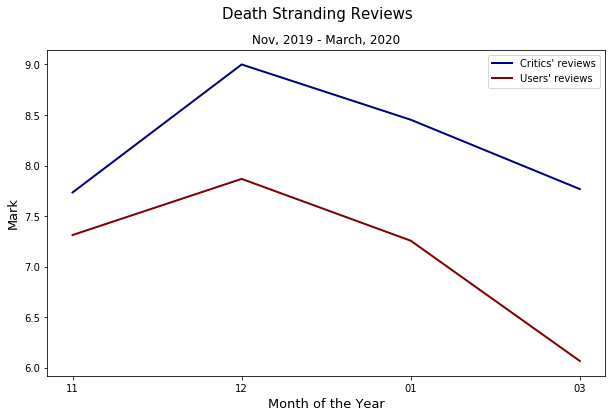

In [6]:
# Визуализируем корреляцию отзывов критиков и пользователей по игре Death Stranding 
# Последние отзывы критиков были в марте, берем тот же временной промежуток по пользователям
# В расчет здесь и далее берется среднее всех отзывов за месяц

DSshort = DS.loc[~DS['Month'].isin([2,4,5,6,7])]
date_index = CRIT['Month'].unique()
AVRсritics = CRIT.groupby(['Month'])['Mark'].mean()
AVRusers = DSshort.groupby(["Month"])['Mark'].mean()

plt.figure(figsize=(10, 6))
plt.plot(date_index, AVRсritics, color = 'navy', linewidth = 2)
plt.plot(date_index, AVRusers, color = "maroon", linewidth = 2)
plt.legend(["Critics' reviews", "Users' reviews"])
title_string = "Death Stranding Reviews"
subtitle_string = "Nov, 2019 - March, 2020"
plt.suptitle(title_string, fontsize=15)
plt.title(subtitle_string, fontsize=12)
plt.xlabel("Month of the Year", fontsize = 13)
plt.ylabel('Mark', fontsize=13)
plt.show()

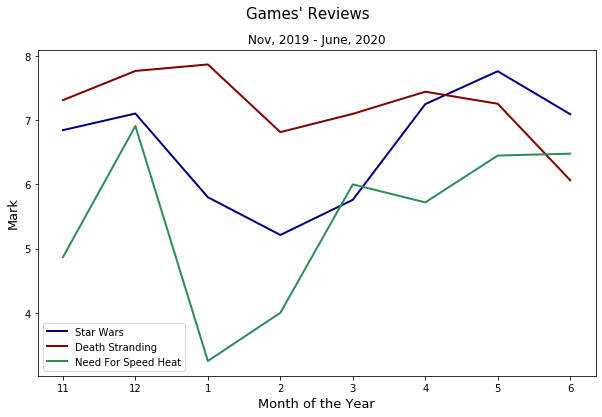

In [7]:
# Посмотрим как соотносится динамика изменения рейтинга игры Death Stranding по сравнению с двумя другими играми, вышедшими 
# в ноябре 2019 года.

SW = pd.read_csv('SW.csv')
NFS = pd.read_csv('NFS.csv')

date_index2 = DS.loc[(DS['Month'] != 7)]["Month"].astype(str).unique()
AVRDS = DS.loc[(DS['Month'] != 7)].groupby(["Month"])['Mark'].mean()
#местами зацеплены отзывы критиков, они в другой шкале, их отфильтровываем из колонки Mark
#отзывы за июль 2020 нам тоже пока не нужны, они не показальны в начале месяца
AVRSW = SW.loc[(SW['Month'] != 7) & (SW['Mark'] <=10)].groupby(['Month'])['Mark'].mean()
AVRNFS = NFS.loc[(NFS['Month'] != 7) & (NFS['Mark'] <= 10)].groupby(['Month'])['Mark'].mean()

plt.figure(figsize=(10, 6))
plt.plot(date_index2, AVRSW, color = 'navy', linewidth = 2) #star wars
plt.plot(date_index2, AVRDS, color = 'maroon', linewidth = 2) #death stranding
plt.plot(date_index2, AVRNFS, color = 'seagreen', linewidth = 2) #need for speed
plt.legend(['Star Wars', 'Death Stranding', 'Need For Speed Heat'])
title_string =  "Games' Reviews"
subtitle_string = "Nov, 2019 - June, 2020"
plt.suptitle(title_string, fontsize=15)
plt.title(subtitle_string, fontsize=12)
plt.xlabel("Month of the Year", fontsize = 13)
plt.ylabel('Mark', fontsize=13)
plt.show()

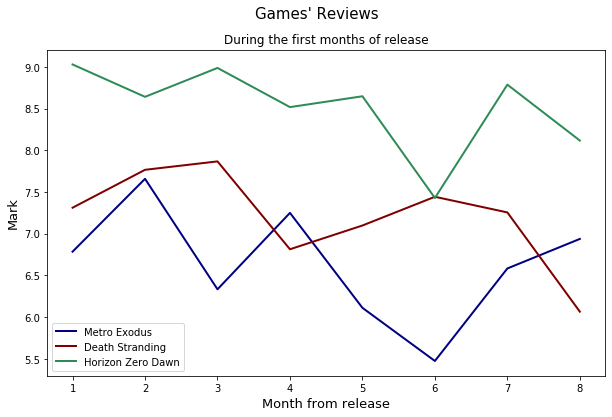

In [8]:
# Посмотрим как соотносится динамика изменения рейтинга игры Death Stranding по сравнению с двумя другими играми того же жанра
# И уровня популярности.
# Поскольку с выхода игры прошло только 8 месяцев, по остальным играм также смотрим этот период времени. 

ME = pd.read_csv("ME.csv")
HRZ = pd.read_csv("HZD.csv")

ME = ME.loc[(ME['Year'] == 2019) & (ME['Mark'] <= 10) & (ME['Month'].isin(range(2,10)))]
AVRME = pd.DataFrame(ME.groupby(["Month"])['Mark'].mean())
AVRME['Month'] = range(1,9)
HRZ = HRZ.loc[(HRZ['Year'] == 2017) & (HRZ['Mark'] <= 10) & (HRZ['Month'].isin(range(2,10)))]
AVRHRZ = pd.DataFrame(HRZ.groupby(["Month"])['Mark'].mean())
AVRHRZ['Month'] = range(1,9)
AVRDS = pd.DataFrame(AVRDS)
AVRDS['Month'] = range(1,9)

date_index3 = AVRDS['Month'].astype(str).unique()
plt.figure(figsize=(10, 6))
plt.plot(date_index3, AVRME['Mark'], color = 'navy', linewidth = 2) #metro exodus
plt.plot(date_index3, AVRDS['Mark'], color = 'maroon', linewidth = 2) #death stranding
plt.plot(date_index3, AVRHRZ['Mark'], color = 'seagreen', linewidth = 2) #horizon zero dawn
plt.legend(['Metro Exodus', 'Death Stranding', 'Horizon Zero Dawn'])
title_string =  "Games' Reviews"
subtitle_string = "During the first months of release"
plt.suptitle(title_string, fontsize=15)
plt.title(subtitle_string, fontsize=12)
plt.xlabel("Month from release", fontsize = 13)
plt.ylabel('Mark', fontsize=13)
plt.show()

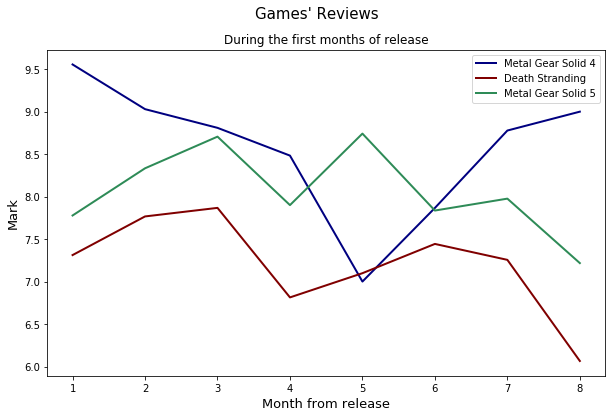

In [9]:
# Посмотрим как соотносится динамика изменения рейтинга игры Death Stranding по сравнению с двумя другими играми того же автора
# Поскольку с выхода игры прошло только 8 месяцев, по остальным играм также смотрим этот период времени. 

MG5 = pd.read_csv('MG5.csv')
MG4 = pd.read_csv('MG4.csv')

MG5 = MG5.loc[((MG5['Year'] == 2015) & (MG5['Month'].isin([9,10,11,12])) | (MG5['Year'] == 2016) & (MG5['Month'].isin([1,2,3,4])))]
MG5 = MG5.loc[(MG5['Mark'] <= 10)]
AVRMG5 = pd.DataFrame(MG5.groupby(["Month"])['Mark'].mean())
AVRMG5['Month'] = range(1,9)

MG4 = MG4.loc[(MG4['Year'] == 2008) & (MG4['Month'].isin(range(5,13)) & (MG4['Mark'] <= 10))]
AVRMG4 = pd.DataFrame(MG4.groupby(["Month"])['Mark'].mean())
AVRMG4['Month'] = range(1,9)

date_index4 = AVRDS['Month'].astype(str).unique()
plt.figure(figsize=(10, 6))
plt.plot(date_index4, AVRMG4['Mark'], color = 'navy', linewidth = 2) #mg4
plt.plot(date_index3, AVRDS['Mark'], color = 'maroon', linewidth = 2) #death stranding
plt.plot(date_index3, AVRMG5['Mark'], color = 'seagreen', linewidth = 2) #mg5
plt.legend(['Metal Gear Solid 4', 'Death Stranding', 'Metal Gear Solid 5'])
title_string =  "Games' Reviews"
subtitle_string = "During the first months of release"
plt.suptitle(title_string, fontsize=15)
plt.title(subtitle_string, fontsize=12)
plt.xlabel("Month from release", fontsize = 13)
plt.ylabel('Mark', fontsize=13)
plt.show()